In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from scipy.stats import randint as sp_randint
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from scipy.stats import expon
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

np.random.seed(0)

In [2]:
dfs = {}
for file in ['../data/MovAve15_Data.csv', '../data/MovAve30_Data.csv',
             '../data/MovAve60_Data.csv', '../data/MovAve90_Data.csv']:
    dfs[file[14:16]] = pd.read_csv(file)

In [3]:
class KFold_Scaled:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, df, y, groups=None):
        from sklearn.model_selection import StratifiedKFold
        from sklearn.preprocessing import LabelEncoder
        import numpy as np

        sk = StratifiedKFold(random_state=0, n_splits=self.n_splits, shuffle=True)

        train_all = df[df['year'] < 1]

        for train_idx, valid_idx in sk.split(np.zeros(train_all.shape[0]),
                                             LabelEncoder().fit_transform(df['year'])):
            yield (train_idx, valid_idx)

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [4]:
class CustomKFold:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, df, y, groups=None):
        from sklearn.model_selection import StratifiedKFold
        import numpy as np

        sk = StratifiedKFold(random_state=0, n_splits=self.n_splits, shuffle=True)

        train_all = df[df['year'] < 2019]

        for train_idx, valid_idx in sk.split(np.zeros(train_all.shape[0]), train_all['year']):
            yield (train_idx, valid_idx)

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

/home/gpt/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


best estimator accuracy for 15: 0.5136


/home/gpt/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


best estimator accuracy for 30: 0.5153


/home/gpt/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


best estimator accuracy for 60: 0.5171


/home/gpt/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


best estimator accuracy for 90: 0.4966


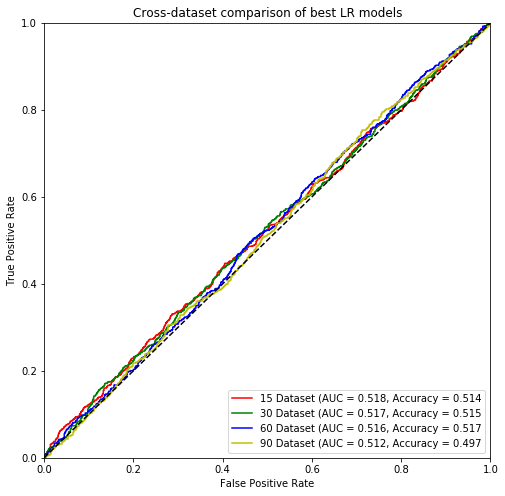

In [10]:
colors = {'15': 'r',
          '30': 'g',
          '60': 'b',
          '90': 'y',
          }
plt.figure(figsize=(8,8))
for name, df in dfs.items():
    
    data_scaled = df.copy()
    scalers = {}

    for col in df:
        if df[col].nunique() > 2:
            scalers[col] = MinMaxScaler((-1, 1))
            data_scaled[col] = scalers[col].fit_transform(df[col].values.reshape(-1, 1))

    train = data_scaled[data_scaled['year'] < 1]
    test = data_scaled[data_scaled['year'] == 1]

    x_train = train.drop(['Target_Var'], axis=1)
    y_train = train['Target_Var']

    x_test = test.drop(['Target_Var'], axis=1)
    y_test = test['Target_Var']
    
    with open('best_lr_model_{}.pckl'.format(name), 'rb') as f:
        lr = pickle.load(f)
    #with open('best_lr_model_cv_{}.pckl'.format(name), 'rb') as f:
    #    lr_cv = pickle.load(f)
    
    accuracy = lr.score(x_test, y_test)
    print('best estimator accuracy for {}: {:.4f}'.format(name, accuracy))
    fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(x_test)[:,1])
    best_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, colors[name], label='{} Dataset (AUC = {:.3f}, Accuracy = {:.3f}'.format(name, best_auc, accuracy))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-dataset comparison of best LR models')

plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig('lr-comparison-datasets.png')


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


best unscaled estimator accuracy for 15: 0.5132
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


best scaled estimator accuracy for 15: 0.5162


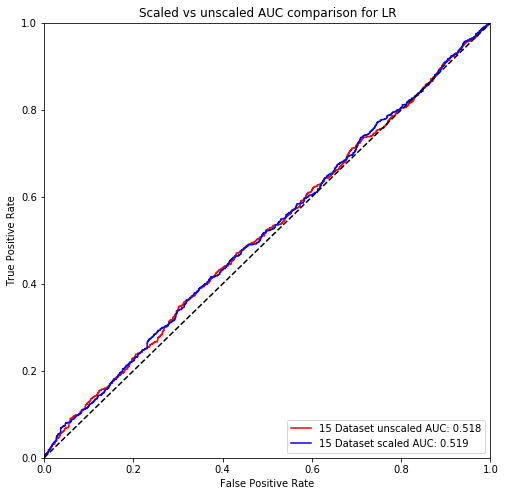

In [11]:
plt.figure(figsize=(8,8))
for name, df in dfs.items():
    if name != '15':
        continue
    
    train = df[df['year'] < 2019]
    test = df[df['year'] == 2019]

    x_train = train.drop(['Target_Var'], axis=1)
    y_train = train['Target_Var']

    x_test = test.drop(['Target_Var'], axis=1)
    y_test = test['Target_Var']

    lr = LogisticRegression(random_state=0,
                            solver='liblinear',
                            )

    params_lr = {'C': expon(scale=1),
                 }

    lr_cv = RandomizedSearchCV(lr,
                               params_lr,
                               n_iter=10,
                               cv=CustomKFold(),
                               scoring='roc_auc',
                               random_state=0,
                               n_jobs=-1,
                               verbose=1,
                               )

    lr_cv.fit(x_train, y_train)

    accuracy = lr_cv.best_estimator_.score(x_test, y_test)
    print('best unscaled estimator accuracy for {}: {:.4f}'.format(name, accuracy))
    fpr, tpr, thresholds = roc_curve(y_test, lr_cv.best_estimator_.predict_proba(x_test)[:,1])
    best_auc = auc(fpr, tpr)

   
    plt.plot(fpr, tpr, 'r', label='15 Dataset unscaled AUC: {:.3f}'.format(best_auc))
    
    data_scaled = df.copy()
    scalers = {}

    for col in df:
        if df[col].nunique() > 2:
            scalers[col] = MinMaxScaler((-1, 1))
            data_scaled[col] = scalers[col].fit_transform(df[col].values.reshape(-1, 1))

    train = data_scaled[data_scaled['year'] < 1]
    test = data_scaled[data_scaled['year'] == 1]

    x_train = train.drop(['Target_Var'], axis=1)
    y_train = train['Target_Var']

    x_test = test.drop(['Target_Var'], axis=1)
    y_test = test['Target_Var']

    lr = LogisticRegression(random_state=0,
                            solver='liblinear',
                            )

    params_lr = {'C': expon(scale=1),
                 }

    lr_cv = RandomizedSearchCV(lr,
                               params_lr,
                               n_iter=10,
                               cv=KFold_Scaled(),
                               scoring='roc_auc',
                               random_state=0,
                               n_jobs=-1,
                               verbose=1,
                               )

    lr_cv.fit(x_train, y_train)

    accuracy = lr_cv.best_estimator_.score(x_test, y_test)
    print('best scaled estimator accuracy for {}: {:.4f}'.format(name, accuracy))
    fpr, tpr, thresholds = roc_curve(y_test, lr_cv.best_estimator_.predict_proba(x_test)[:,1])
    best_auc = auc(fpr, tpr)

   
    plt.plot(fpr, tpr, 'b', label='15 Dataset scaled AUC: {:.3f}'.format(best_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Scaled vs unscaled AUC comparison for LR')
    plt.legend(loc='lower right')
    plt.savefig('unscaled-scaled-comparison-lr.png')
    plt.show()